In [1]:
import pandas as pd
import numpy as np
import random
import math
import re
from scipy.special import psi #digamma function
from scipy.special import polygamma #derivative of digamma function
from scipy.special import loggamma
from IPython.display import display
import numpy.random
from nltk.tokenize import wordpunct_tokenize
import sys
import csv
import nltk
from nltk.corpus import stopwords #import stopwords
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import time
import matplotlib.pyplot as plt
import numpy.random

In [2]:
np.random.seed(1234)
meanchangethresh = 1e-3
MAXITER = 10000

In [3]:
def getVocab(file):
	#getting vocab dictionary from a csv file (nostopwords)'''
	vocab = dict()
	with open(file, 'r') as infile:
		reader = csv.reader(infile)
		for index, row in enumerate(reader):
			vocab[row[0]] = index

	return vocab

In [4]:
def getDocs(file_path):
    with open(file_path,encoding="utf-8") as f:
        docs=f.readlines()
        
    return(docs)

In [5]:
def dirichlet_expectation(a):
    if (len(a.shape)==1):
        return (psi(a)-psi(np.sum(a)))
    return (psi(a)-psi(np.sum(a,1))[:,np.newaxis])

In [6]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [7]:
def parseDocument(doc, vocab):
    #preprocessing document data
	wordslist = list()
	countslist = list()
	doc = doc.lower()
	tokens = nltk.word_tokenize(doc)#wordpunct_tokenize(doc)
	remove_chars = '[0-9’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    
	tokens=[re.sub(remove_chars,"",x.lower()) for x in tokens]
	tokens=[x for x in tokens if x!='']
    # 词形还原
	tagged_sent = pos_tag(tokens)
	wnl = WordNetLemmatizer()
	lemmas_sent = []
	for tag in tagged_sent:
		wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN
		lemmas_sent.append(wnl.lemmatize(tag[0], pos=wordnet_pos)) 
	tokens=lemmas_sent

	dictionary = dict()
	for word in tokens:
		if word in vocab:
			wordtk = vocab[word]
			if wordtk not in dictionary:
				dictionary[wordtk] = 1
			else:
				dictionary[wordtk] += 1

	wordslist.append(dictionary.keys())
	countslist.append(dictionary.values())
	return (wordslist[0], countslist[0])

In [8]:
class VEMLDA():
    def __init__(self, vocab, K, D, alpha, beta, docs, iterations, parsed = False):
        self._vocab=vocab
        self._K=K
        self._D=D
        self._alpha=alpha
        self._beta=beta
        self._docs=docs
        self._iterations=iterations
        self._parsed=parsed
        self._V=len(self._vocab)
        self._phi={}
        self._gamma=np.zeros((self._D,self._K))
        self._Nd=np.zeros(self._D,dtype=np.int)
        self._newdocs={}
        self._ELBO=list() #recoding ELBO in each iteration
        self._ct=0
        
        
    def convert_docs(self):
        
        for d in range(D):
            parsed_docs = parseDocument(self._docs[d],self._vocab)
            (words,counts)=parsed_docs
            newdoc=[]
            
            N_d = int(sum(counts))
            for i, item in enumerate(counts):
                for j in range(item):
                    newdoc.append(list(words)[i])
            assert len(newdoc) == N_d, "error"
            
            self._newdocs[d]=newdoc
            self._Nd[d]=int(N_d)
            
        
        
    def init_gamma_phi(self):
        self._phi={}
        
        for d in range(self._D):
    
            N_d = int(self._Nd[d])
            phi_d = np.zeros((N_d,self._K))
            gamma_d = np.zeros(self._K)
            
            for n in range(N_d):
                phi_d[n]=np.repeat(1.0/self._K,self._K)

            for k in range(self._K):
                gamma_d[k]=self._alpha[k]+N_d/self._K
            
            self._gamma[d]=gamma_d
            self._phi[d]=phi_d
    
    
    def Update_beta(self):
        
        for k in range(self._K):
            for v in range(self._V):
                self._beta[k][v]=0
                for d in range(self._D):
                    for n in range(self._Nd[d]):
                        if self._newdocs[d][n]==v:
                            self._beta[k][v] += self._phi[d][n][k]
            
            self._beta[k] = self._beta[k]/np.sum(self._beta[k])
            
        #print(self._beta)
            
            
    def Update_gamma(self,phi_d):
        new_gamma_d = np.zeros(self._K)
        
        new_gamma_d = self._alpha + np.sum(phi_d,axis = 0)
        
        return (new_gamma_d)
        
        
    
    
    def Update_phi(self,doc_id):
        new_phi = np.zeros([self._Nd[doc_id],self._K])
                
        for n in range(self._Nd[doc_id]):
            for k in range(self._K):
                new_phi[n][k] = self._beta[k][self._newdocs[doc_id][n]] * math.exp(psi(self._gamma[doc_id][k]))
            new_phi[n] = new_phi[n]/np.sum(new_phi[n])
            
        return (new_phi)
            
            
    def Update_alpha(self):
        new_alpha = np.zeros(self._K)
        g = np.zeros(self._K)
        h = np.zeros(self._K)
        z = 0
        c = 0
        
        z = self._D * polygamma(1,sum(self._alpha))
        h = -self._D * polygamma(1,self._alpha)
        g = -self._D * dirichlet_expectation(self._alpha)
        
        for d in range(self._D):
            g += dirichlet_expectation(self._gamma[d])
            
        c=sum(g/h)/(1/z+sum(1/h))
        
        for k in range(self._K):
            new_alpha[k]=self._alpha[k]-((g[k]-c)/h[k])
            
        return (new_alpha)
            
            
    def Calculate_likelihood(self):
        
        l = 0
        
        for d in range(self._D):
            l += loggamma(sum(self._alpha)) - sum(loggamma(self._alpha)) - loggamma(sum(self._gamma[d])) + sum(loggamma(self._gamma[d]))
            l += sum((self._alpha-self._gamma[d]) * dirichlet_expectation(self._gamma[d]))
            for n in range(self._Nd[d]):
                l += sum(self._phi[d][n] * dirichlet_expectation(self._gamma[d]))
                l += sum(self._phi[d][n] * np.log(self._beta[:,self._newdocs[d][n]]))
                l += sum(self._phi[d][n] * np.log(self._phi[d][n]))
                
        return(l)
    
    
    def Calculate_doc_likelihood(self,doc_id,gamma_d,phi_d):
        l = 0
        
        
        l +=  - loggamma(sum(gamma_d)) + sum(loggamma(gamma_d))
        l += sum((self._alpha-gamma_d) * dirichlet_expectation(gamma_d))
        for n in range(self._Nd[doc_id]):
            l += sum(phi_d[n] * dirichlet_expectation(gamma_d))
            l += sum(phi_d[n] * np.log(self._beta[:,self._newdocs[doc_id][n]]))
            l += sum(phi_d[n] * np.log(phi_d[n]))
                
        return(l)
    
    
    
    def Calculate_alpha_likelihood(self,alpha):
        l = 0
        
        for d in range(self._D):
            l += self._D*(loggamma(sum(alpha)) - sum(loggamma(alpha)))
            l += sum(alpha * dirichlet_expectation(self._gamma[d]))
            
        return l    
        
    
    
    def E_step(self,doc_id):
        #print ("E-step: Variational Inference")
        like_old=-np.inf
        like_new=-np.inf
        
        for i in range(self._iterations):
            
            phi_d = self.Update_phi(doc_id)
            
            gamma_d = self.Update_gamma(phi_d)
            
            #like_new = self.Calculate_doc_likelihood(doc_id,gamma_d,phi_d)
            #if ((like_new-like_old)<meanchangethresh):
                #break
            
            meanchange = np.mean(abs(gamma_d - self._gamma[doc_id]))
            if (meanchange < meanchangethresh):
                break
                
            self._phi[doc_id] = phi_d
            self._gamma[doc_id] = gamma_d
            #like_old = like_new
            #print("this is phi",doc_id,phi_d)
            #print("this is gamma",doc_id,gamma_d)
            
            
    def M_step(self):
        #print ("M-step: Update Model Parameters")
        like_old=-np.inf
        like_new=-np.inf
        
        for i in range(self._iterations):
            
            new_alpha = self.Update_alpha()
            #print(self._alpha,new_alpha)
            #like_new = self.Calculate_alpha_likelihood(new_alpha)
            #if ((like_new-like_old)<meanchangethresh):
                #break
            if (new_alpha<=0).any():
                break
            meanchange = (self._alpha-new_alpha)
            if (all(meanchange < meanchangethresh)):
                break
                
            self._alpha = new_alpha
            like_old = like_new
            print(self._alpha)
            
        self.Update_beta()
        
        
    
    def runVEM(self):
        new_ELBO = - np.inf
        old_ELBO = - np.inf
        self.convert_docs()
        
        for i in range(self._iterations):
            
            print ("ITERATION", i)
            if self._parsed == False:
                
                self.init_gamma_phi()
                print ("E-step: Variational Inference")
                for d in range(self._D):
                    #print ("E-step: Variational Inference",d)
                    self.E_step(d)
                print ("M-step: Update Model Parameters")
                self.M_step()

                new_ELBO = self.Calculate_likelihood()

                meanchange = (new_ELBO - old_ELBO)
                if (meanchange < meanchangethresh):
                    break

                self._ELBO.append(new_ELBO)
                old_ELBO = new_ELBO
                self._ct+=1
                
                print(i,"th ELBO is",new_ELBO)
                
                
        
    def plotELBO(self):
        if len(self._ELBO)==0:
            print ("ERROR: No iteration now")

        plt.plot(range(self._ct),self._ELBO)
        plt.xlabel("iteration")
        plt.ylabel("ELBO")
        plt.show()

    def show_topic_words(self):
        topic_words=[]
        max_num=10
        for i in range(0,K):
            #topic_words.append([])
            sorted_beta_index=self._beta[i,:].argsort()
            topicword=[]
            key_list=list(self._vocab.keys())
            value_list=list(self._vocab.values())
            for j in sorted_beta_index:
                pos=value_list.index(j)
                topicword.insert(0,key_list[j])
            topic_words.append(topicword[0:min(max_num,len(topicword))])
        print(topic_words)
        
        

In [9]:
def Generate_Data(num_topic,voc_size,num_doc,xi,alpha,eta):
    num_word=np.repeat(xi,num_doc)#np.random.poisson(xi,num_doc) #number of words in each document
    
    beta=np.zeros([num_topic,voc_size])
    for i in range(num_topic):
        beta[i]=np.random.dirichlet(eta)
    
    theta=np.zeros([num_doc,num_topic])
    for d in range(num_doc):
        theta[d]=np.random.dirichlet(alpha)
    
    doc={}
    for d in range(num_doc):
        W=np.zeros([voc_size,num_word[d]])
        for n in range(num_word[d]):
            z=np.random.multinomial(1,theta[d])
            topic_index=np.where(z==1)[0][0]
            w=np.random.multinomial(1,beta[topic_index,])
            W[:,n]=w
        doc[d]=W
                            
    return doc,beta,theta




In [10]:
np.random.seed(12345)
K=2
V=8
D=1000
xi=100
true_alpha=[0.05 for i in range(K)]
true_eta=[1.0 for i in range(V)]
docs,true_beta,true_theta=Generate_Data(K,V,D,xi,true_alpha,true_eta)

In [11]:
vocab={'i': 0,
 'new': 1,
 'percent': 2,
 'people': 3,
 'year': 4,
 'two': 5,
 'million': 6,
 'president': 7}
key_list=list(vocab.keys())
value_list=list(vocab.values())

In [12]:
new_docs=list()
for d in range(D):
    new_doc = ""
    Nd = len(docs[d][0])
    for n in range(Nd):
        pos = np.where(docs[d][:,n]==1)[0][0]
        new_doc += " "+key_list[pos]
    new_docs.append(new_doc)

In [13]:
#initialize alpha and beta

alpha=np.array([0.1,0.1])

beta=np.zeros([K,V])
for i in range(0,K):
    beta_sum=0
    beta[i]=np.random.gamma(10,0.1,V)
    beta_sum=sum(beta[i])
    beta[i]=beta[i]/beta_sum


ITERATION 0
E-step: Variational Inference
M-step: Update Model Parameters
0 th ELBO is -256036.47061614835
ITERATION 1
E-step: Variational Inference
M-step: Update Model Parameters
[0.11156029 0.08063981]
1 th ELBO is -189363.84408117458
ITERATION 2
E-step: Variational Inference
M-step: Update Model Parameters
[0.09724988 0.0795196 ]
2 th ELBO is -185478.47912913313
ITERATION 3
E-step: Variational Inference
M-step: Update Model Parameters
[0.09342916 0.08480112]
Running time: 159.64052891731262 seconds


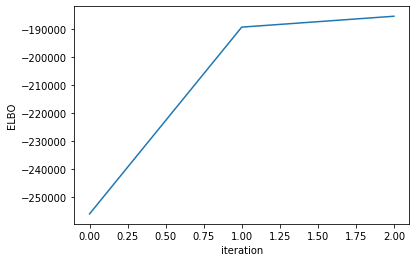

In [14]:
start=time.time()

iterations = 20

test = VEMLDA(vocab=vocab, K=K, D=D, alpha=alpha, beta=beta, docs=new_docs, iterations=iterations)
test.runVEM()
end=time.time()
print ("Running time:",str(end-start),"seconds")
test.plotELBO()

In [15]:
np.around(test._alpha,3)

array([0.093, 0.085])

In [16]:
pd.DataFrame(np.around(test._beta,3))

,0,1,2,3,4,5,6,7
0,0.278,0.041,0.021,0.024,0.087,0.092,0.348,0.109
1,0.158,0.125,0.164,0.380,0.000,0.013,0.038,0.122


In [17]:
pd.DataFrame(np.around(true_beta,3))

,0,1,2,3,4,5,6,7
0,0.276,0.040,0.021,0.024,0.087,0.094,0.347,0.110
1,0.160,0.123,0.160,0.377,0.001,0.013,0.041,0.124


In [18]:
np.around(true_theta[0:10],3)

array([[0.028, 0.972],
       [0.998, 0.002],
       [0.   , 1.   ],
       [1.   , 0.   ],
       [0.021, 0.979],
       [0.857, 0.143],
       [1.   , 0.   ],
       [0.   , 1.   ],
       [0.001, 0.999],
       [0.988, 0.012]])

In [19]:
gamma=np.zeros((D,K))

for d in range(D):
    gamma[d]=test._gamma[d]/sum(test._gamma[d])
    
pd.DataFrame(np.around(gamma[0:10],3))

,0,1
0,0.001,0.999
1,0.999,0.001
2,0.001,0.999
3,0.999,0.001
4,0.001,0.999
5,0.803,0.197
6,0.991,0.009
7,0.001,0.999
8,0.001,0.999
9,0.995,0.005
